### Load data

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')
heart = 'E11444_LMNA'
slice_name = 'E11444_09_SC2'


def load_slice_data(path, heart, slice_name):
    data = pd.read_pickle(path.joinpath(heart, 'Stats',
                                        slice_name).with_suffix('.pkl'))
    return data

data = load_slice_data(path, heart, slice_name)
data.describe()

,label,centroid-0,centroid-1,major_axis_length,minor_axis_length,orientation,solidity,density,tangent,distance,area,euler_number
count,45651.000000,45651.000000,45651.000000,45651.000000,45651.000000,45651.000000,45651.000000,45651.000000,45651.000000,45651.000000,45651.000000,45651.000000
mean,22826.000000,1845.729452,1926.775674,3.511799,1.360982,0.494300,0.936622,0.164059,-0.089876,0.544058,13.956189,0.841537
std,13178.452906,850.186350,931.055805,9.022472,3.536269,0.747224,0.124523,0.112862,0.893288,0.274844,213.201579,4.329571
min,1.000000,271.000000,375.000000,0.000000,0.000000,-1.570796,0.177954,0.000000,-1.567844,0.000000,1.000000,-477.000000
25%,11413.500000,1008.000000,1032.895238,0.000000,0.000000,0.000000,0.916667,0.072549,-0.785398,0.322865,1.000000,1.000000
50%,22826.000000,1983.250000,1931.000000,2.000000,0.000000,0.785398,1.000000,0.146078,-0.241435,0.560691,2.000000,1.000000
75%,34238.500000,2588.000000,2838.142857,4.000000,1.788854,0.785398,1.000000,0.230882,0.490538,0.776958,6.000000,1.000000
max,45651.000000,3274.000000,3567.000000,436.198373,174.860112,1.570796,1.000000,0.692157,1.570796,1.000000,24882.000000,1.000000


### Select group of clusters (Optional)

In [3]:
data_100 = data[data['area'].between(100, 200)]

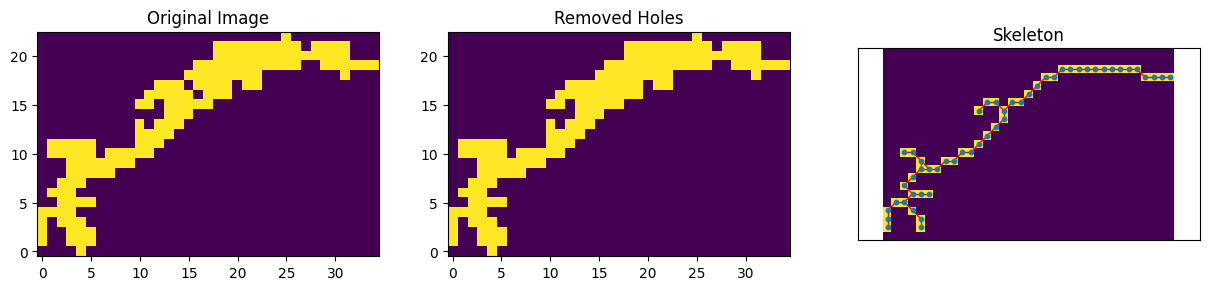

In [4]:
from skimage import morphology
from skimage import graph as skgraph
import networkx as nx


def remove_holes(image, area_threshold=3):
    return morphology.remove_small_holes(image > 0,
                                         area_threshold=area_threshold)


def medial_axis(image):
    _, distance = morphology.medial_axis(image,
                                         return_distance=True)
    return distance

def skeletonize(image):
    return morphology.skeletonize(image, method='lee')

def to_graph(skeleton):
    matrix, nodes = skgraph.pixel_graph(skeleton, mask=skeleton > 0,
                                        connectivity=2)
    graph = nx.from_scipy_sparse_array(matrix, edge_attribute='length')
    return graph


def add_node_attributes(graph, attrs, name):
    nodes = graph.nodes
    attrs = [tuple((x, y)) for x, y in attrs.tolist()]

    nx.set_node_attributes(graph, dict(zip(nodes, attrs)), name=name)
    return graph

def graph_builder(skeleton):
    graph = to_graph(skeleton)
    graph = add_node_attributes(graph, np.argwhere(skeleton), 'pos')
    return graph


im = data_100['image'].iloc[0]
im_ = remove_holes(im)
skeleton = skeletonize(im_)
G = graph_builder(skeleton)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(im.T, origin='lower')
axs[0].set_title('Original Image')
axs[1].imshow(im_.T, origin='lower')
axs[1].set_title('Removed Holes')
axs[2].imshow(skeleton.T, origin='lower')
axs[2].set_title('Skeleton')

nx.draw_networkx(G, pos=nx.get_node_attributes(G, 'pos'), ax=axs[2],
                 node_size=10, with_labels=False, edge_color='r')
plt.show()

### Remove triangle cycles

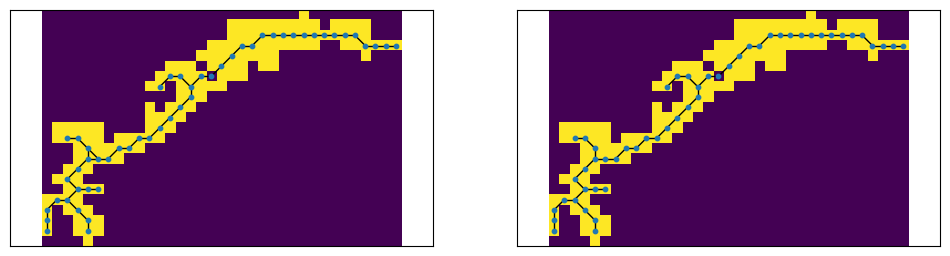

In [5]:
import itertools


def remove_triangle_cycles(graph, nodes, degrees):
    '''Remove edges which form triangles on branching points
    '''
    subgraph = graph.subgraph(nodes[degrees != 2])

    for nodes in nx.cycle_basis(subgraph):

        if len(nodes) != 3:
            continue

        cycle_edges = list(itertools.combinations(nodes, 2))
        length = [graph.get_edge_data(u, v)['length'] for u, v in cycle_edges if graph.has_edge(u, v)]

        if len(length) != 3:
            continue

        max_length_edge = cycle_edges[np.argmax(length)]
        graph.remove_edge(*max_length_edge)

    return graph


nodes, degrees = np.array(list(G.degree)).T

G_ = G.copy()
G = remove_triangle_cycles(G, nodes, degrees)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(im.T, origin='lower')
nx.draw_networkx(G_, pos=G.nodes(data='pos'), node_size=10,
                 with_labels=False, ax=axs[0])
axs[1].imshow(im.T, origin='lower')
nx.draw_networkx(G, pos=G.nodes(data='pos'), node_size=10,
                 with_labels=False, ax=axs[1])
plt.show()

### Simplify graph

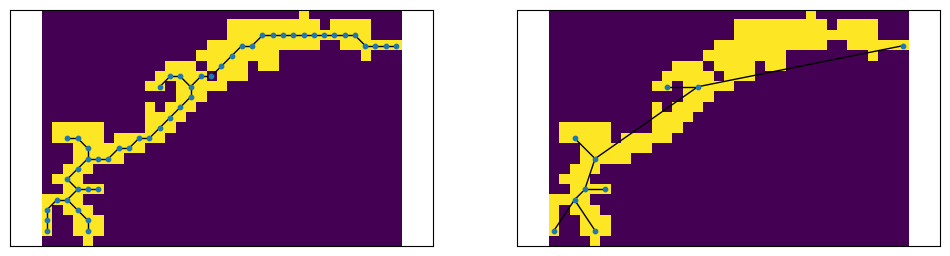

In [6]:
def get_degree(graph):
    return np.array(graph.degree()).T


def reduce_graph(graph, nodes, degrees):
    new_nodes = nodes[degrees != 2]
    reduced_graph = graph.subgraph(new_nodes).copy()
    path = {}
    for edge in reduced_graph.edges:
        path[edge] = list(edge)

    nx.set_edge_attributes(reduced_graph, path, name='path')

    return reduced_graph


def add_merged_edges(reduced_graph, graph, nodes, degrees):
    edge_graph = graph.subgraph(nodes[degrees == 2])
    new_nodes = nodes[degrees != 2]
    
    for line in nx.connected_components(edge_graph):
        edge = []
        for ll in line:
            for node in new_nodes:
                if graph.has_edge(ll, node):
                    edge.append(node)

        path = edge + list(line)
        g = graph.subgraph(path)

        reduced_graph.add_edge(*edge, length=g.size(weight="length"),
                               path=path)
        
    return reduced_graph


nodes, degrees = np.array(list(G.degree())).T
G_r = reduce_graph(G, nodes, degrees)
G_r = add_merged_edges(G_r, G, nodes, degrees)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(im.T, origin='lower')
nx.draw_networkx(G, pos=G.nodes(data='pos'),
                 node_size=10, with_labels=False, ax=axs[0])
axs[1].imshow(im.T, origin='lower')
nx.draw_networkx(G_r, pos=G_r.nodes(data='pos'),
                 node_size=10, with_labels=False, ax=axs[1])
plt.show()

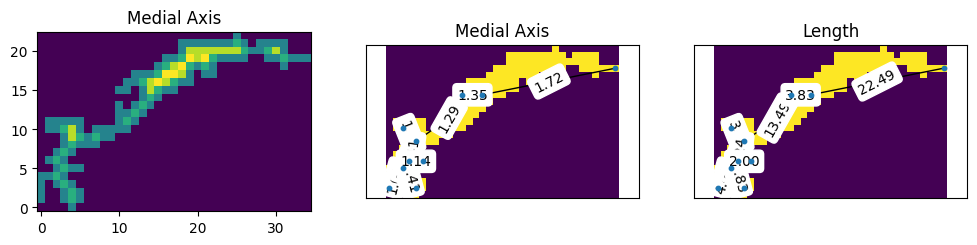

In [8]:
medial_axis_image = medial_axis(im_)
medial_axis_list = medial_axis_image[skeleton > 0]

medial_axis_attr = {}
for u, v, data in G_r.edges(data=True):
    medial_axis_attr[(u, v)] = np.mean(medial_axis_list[data['path']])

nx.set_edge_attributes(G_r, medial_axis_attr, name='medial_axis')


edge_labels = [f"{data['medial_axis']:.2f}" for u, v, data in G_r.edges(data=True)]
edge_lengths = [f'{data["length"]:.2f}' for u, v, data in G_r.edges(data=True)]

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
axs[0].imshow(medial_axis_image.T, origin='lower')
axs[0].set_title('Medial Axis')

axs[1].imshow(im_.T, origin='lower')
nx.draw_networkx(G_r, pos=G_r.nodes(data='pos'), ax=axs[1],
                 node_size=10, with_labels=False)
nx.draw_networkx_edge_labels(G_r, pos=G_r.nodes(data='pos'), ax=axs[1],
                 edge_labels=dict(zip(G_r.edges, edge_labels)))
axs[1].set_title('Medial Axis')

axs[2].imshow(im_.T, origin='lower')
nx.draw_networkx(G_r, pos=G_r.nodes(data='pos'), ax=axs[2],
                 node_size=10, with_labels=False)
nx.draw_networkx_edge_labels(G_r, pos=G_r.nodes(data='pos'), ax=axs[2],
                 edge_labels=dict(zip(G_r.edges, edge_lengths)))
axs[2].set_title('Length')

plt.show()